In [1]:
import pandas as pd
import numpy as np

In [2]:
##############
# 데이터 정보
#############
'''
수집 데이터 : Kaggle Flight Prices Dataset (https://www.kaggle.com/datasets/dilwong/flightprices)
용도 : 프로젝트 1-stage 항공권 가격 예측 모델 학습 목적 활용
'''
##############
# 데이터 로드
#############

#원본 데이터
'''
row x column : (82138753, 27)
total data point : 2,217,746,331 (약 22억)
data size : 약 30GB
'''
'''전체 데이터 셋 (참고1)'''
original_data = pd.read_csv('./itineraries.csv')  

##############
# 전처리
#############

# 사용할 feature 선택 
'''27개 feature 중 학습에 사용할 7개 feature 선택'''

temp_feature = ['elapsedDays','baseFare','segmentAirlineCode ']
feature = ['flightDate','startingAirport','destinationAirport','travelDuration','isNonStop','totalFare','totalTravelDistance']

'''
row x column : (82138753, 7)
total data point : 574,971,271 (약 6억)
'''

feature_data = original_data[feature]

# 중복 데이터 제거
'''여행기간이 분단위로 차이나는 것외에 모든 정보가 동일하다면 해당 데이터도 중복으로 판단하고 제거 (참고2)'''

columns_to_exclude = ['travelDuration']
filtered_columns = [col for col in feature_data.columns if col not in columns_to_exclude]

'''
row x column : (12709654, 7)
total data point : 88,967,578 (약 0.9억)
data size : 약 600MB
'''
'''중복 제거 데이터 (참고3)'''
df= feature_data.drop_duplicates(subset=filtered_columns, keep = 'first')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# 여행시간(travelDuration) 분 단위로 통일
def convert_to_minutes(duration):
    if 'T' not in duration:
        days = duration
        hours = 0
        minutes = 0
    else :
        days, time = duration.split('T')

        if 'H' not in time:
            hours = 0
            minutes = time
        else :
            hours, minutes = time.split('H')
            hours = int(hours)
        minutes = 0 if len(minutes) <= 1 else int(minutes[:-1])
    days = 0 if len(days) == 1 else int(days[1:-1]) 
    total_minutes = days*24*60 + hours*60 + minutes 
    return total_minutes
df['travelTime'] = df['travelDuration'].apply(convert_to_minutes)
# 날짜 데이터 변환
date_parts = df['flightDate'].str.split('-')
df['year'] = date_parts.str[0].astype(int)
df['month'] = date_parts.str[1].astype(int)
df['day'] = date_parts.str[2].astype(int)
df = df[['year','month','day','startingAirport','destinationAirport','isNonStop','travelTime','totalTravelDistance','totalFare']]
# 전처리 데이터 저장 (데이터 로드 효율성 고려)
'''
row x column : (11578701, 9)
total data point : 104,208,309 (약 1억)
data size : 약 460MB
'''
df.to_csv('./preprocessed_data.csv', index = False)

In [84]:
data = pd.read_csv('./preprocessed_data.csv')
data

,year,month,day,startingAirport,destinationAirport,isNonStop,travelTime,totalTravelDistance,totalFare
0,2022,4,17,ATL,BOS,True,149,947.0,248.60
1,2022,4,17,ATL,BOS,False,252,956.0,251.10
2,2022,4,17,ATL,BOS,False,286,947.0,252.60
3,2022,4,17,ATL,BOS,False,345,1462.0,252.60
4,2022,4,17,ATL,BOS,True,158,947.0,300.10
...,...,...,...,...,...,...,...,...,...
11578696,2022,11,12,ORD,LAX,False,430,1875.0,198.60
11578697,2022,11,12,ORD,LAX,False,956,3145.0,199.20
11578698,2022,11,12,ORD,LAX,False,428,2225.0,224.60
11578699,2022,11,12,ORD,LAX,False,559,3198.0,228.59


# 1. 독립 모델 (비 시계열 접근법)
- **접근 방식** : 
> 날짜 데이터를 `연`, `월`, `일` 세 개의 feature로 분리하여 학습
- **이유** : 
> 출발 및 도착 지역에 대한 동일한 날짜 데이터가 많아,  
        시퀀스 데이터를 input으로 사용하는 시계열 접근 방식을 사용하기에 애매함.
- **장점** : 
> 시퀀스 데이터로 변경하지 않기 때문에 모델 작성이 간편
- **단점** : 
> 각각의 데이터 샘플을 하나씩 학습하므로 시간에 따른 가격 변동 추이를 파악하기엔 어려울 수 있음


In [28]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import optuna

In [34]:
from category_encoders import OneHotEncoder

In [38]:
feature = ['startingAirport', 'destinationAirport','isNonStop','duration_minutes','year','month','day']
target = 'totalFare'
X_train,X_test, y_train, y_test = train_test_split(data[feature], data[target], test_size=0.2,)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.2)

In [39]:
X_train.shape,X_test.shape, X_test.shape, y_train.shape, y_val.shape ,y_test.shape

((7410368, 7), (1852592, 7), (2315741, 7), (7410368,), (1852592,), (2315741,))

In [36]:
X_train

,startingAirport,destinationAirport,travelDuration,isNonStop,duration_minutes,year,month,day
7638996,SFO,DFW,PT8H2M,False,482,2022,8,3
9489487,DTW,MIA,PT6H15M,False,375,2022,9,3
2003513,LAX,CLT,PT8H42M,False,522,2022,7,3
9950187,PHL,CLT,PT4H23M,False,263,2022,10,25
3800704,JFK,PHL,PT6H59M,False,419,2022,6,7
...,...,...,...,...,...,...,...,...
4948422,ATL,DTW,PT5H14M,False,314,2022,7,9
1176668,LAX,EWR,PT5H25M,True,325,2022,6,6
11002725,BOS,CLT,PT2H30M,True,150,2022,9,29
4119983,OAK,DFW,PT9H42M,False,582,2022,8,6


In [40]:
encoder = OneHotEncoder(use_cat_names=True)
X_train_EN = encoder.fit_transform(X_train)
X_val_EN = encoder.transform(X_val)
X_test_EN = encoder.transform(X_test)

In [41]:
X_train_EN

,startingAirport_MIA,startingAirport_DTW,startingAirport_DFW,startingAirport_OAK,startingAirport_ORD,startingAirport_PHL,startingAirport_ATL,startingAirport_LGA,startingAirport_SFO,startingAirport_BOS,...,destinationAirport_JFK,destinationAirport_SFO,destinationAirport_LAX,destinationAirport_IAD,destinationAirport_CLT,isNonStop,duration_minutes,year,month,day
1245572,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,False,852,2022,5,6
5154342,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,False,501,2022,7,8
8360026,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,False,460,2022,8,12
7584944,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,False,924,2022,8,30
10124000,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,False,325,2022,10,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8989622,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,False,511,2022,10,3
1982687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,False,478,2022,6,20
3696382,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,True,151,2022,8,2
4085201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,False,794,2022,7,7


In [54]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score

In [42]:
model_dt = DecisionTreeRegressor()
model_rf = RandomForestRegressor()
model_xgb = XGBRegressor()

In [43]:
model_dt.fit(X_train_EN,y_train)
model_rf.fit(X_train_EN,y_train)
model_xgb.fit(X_train_EN,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [52]:
pred_dt = model_dt.predict(X_val_EN)
mae_dt = mae(y_val, pred_dt)
mse_dt = mse(y_val, pred_dt)
rmse_dt = mse(y_val, pred_dt,squared=False)
r2_dt = r2_score(y_val, pred_dt)

pred_rf = model_rf.predict(X_val_EN)
mae_rf = mae(y_val, pred_rf)
mse_rf = mse(y_val, pred_rf)
rmse_rf = mse(y_val, pred_rf,squared=False)
r2_rf = r2_score(y_val, pred_rf)


pred_xgb = model_xgb.predict(X_val_EN)
mae_xgb = mae(y_val, pred_xgb)
mse_xgb = mse(y_val, pred_xgb)
rmse_xgb = mse(y_val, pred_xgb,squared=False)
r2_xgb = r2_score(y_val, pred_xgb)

In [65]:
baseline = {'Model': ['Decision Tree', 'Random Forest','XGBoost'], 'MAE': [mae_dt, mae_rf, mae_xgb], 'MSE': [mse_dt,mse_rf,mse_xgb],'RMSE':[rmse_dt,rmse_rf,rmse_xgb],'R2':[r2_dt,r2_rf,r2_xgb]}
result_baseline = pd.DataFrame(baseline)
result_baseline = result_baseline.round(2)

In [69]:
result_baseline

,Model,MAE,MSE,RMSE,R2
0,Decision Tree,85.95,23666.69,153.84,0.52
1,Random Forest,81.62,19878.09,140.99,0.60
2,XGBoost,110.82,28280.85,168.17,0.43


In [70]:
import pickle
'''
baseline 모델을 재활용할 수 있도록 저장
용량 :
Decision Tree : 330MB
Random Forest : 26GB
XGBoost : 490KB
→ 현재 프로젝트에서 웹 배포용으로 Random Forest, Decision Tree 모델을 사용하기엔 무리가 있으며, XGBoost가 속도 측면에서 적절해 보이지만 성능은 떨어지는 편
'''
# 모델 저장
with open('baseline_dt.pkl','wb') as f:
    pickle.dump(model_dt, f)
with open('baseline_rf.pkl','wb') as f:
    pickle.dump(model_rf, f)
with open('baseline_xgb.pkl','wb') as f:
    pickle.dump(model_xgb, f)
# 모델 불러오기
# with open('baseline_dt.pkl','rb') as f:
#     baseline_dt = pickle.load(f)
# with open('baseline_rf.pkl','rb') as f:
#     baseline_rf = pickle.load(f)
# with open('baseline_xgb.pkl','rb') as f:
#     baseline_xgb = pickle.load(f)

KeyboardInterrupt: 

# 2. 시계열 모델
- **접근 방식** : 
> 1) 날짜 순으로 데이터를 정렬해 데이터를 시퀀스 단위로 묶어서 학습  
> 2) 동일한 출발 지역, 도착 지역인 데이터에 대해서 날짜를 기준으로 데이터 통합(평균 or 중위)하는 과정이 필요
- **이유** : 
> 출발 및 도착 지역에 대해서 동일한 날짜 데이터가 많아, Sliding window를 사용해 시퀀스 데이터를 만들기 어려움  
> 해결 방안으로는 동일 날짜, 출발 및 도착 지역에 대해서 데이터를 통합하는 방법을 사용할 수 있음
- **장점** : 
> 시퀀스 데이터를 순환신경망(LSTM, GRU, RNN)에 사용하여 시간에 따른 가격의 추이를 학습시킬 수 있음
- **단점** : 
> 각각의 데이터 샘플을 통합해 모델을 학습시키므로 실제 모델 테스트 단계에서 오차가 크게 발생할 수 있음


### 참고 1. 전체 데이터 세트

In [3]:
original_data.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach
2,98d90cbc32bfbb05c2fc32897c7c1087,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650218700,2022-04-17T14:05:00.000-04:00,BOS,ATL,Delta,DL,Boeing 757-200,9000,947,coach
3,969a269d38eae583f455486fa90877b4,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H32M,0,False,False,...,1650227460,2022-04-17T16:31:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9120,947,coach
4,980370cf27c89b40d2833a1d5afc9751,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H34M,0,False,False,...,1650213180,2022-04-17T12:33:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9240,947,coach


In [5]:
data.columns

Index(['legId', 'searchDate', 'flightDate', 'startingAirport',
       'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays',
       'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode'],
      dtype='object')

### 참고 2. 중복 데이터 제거
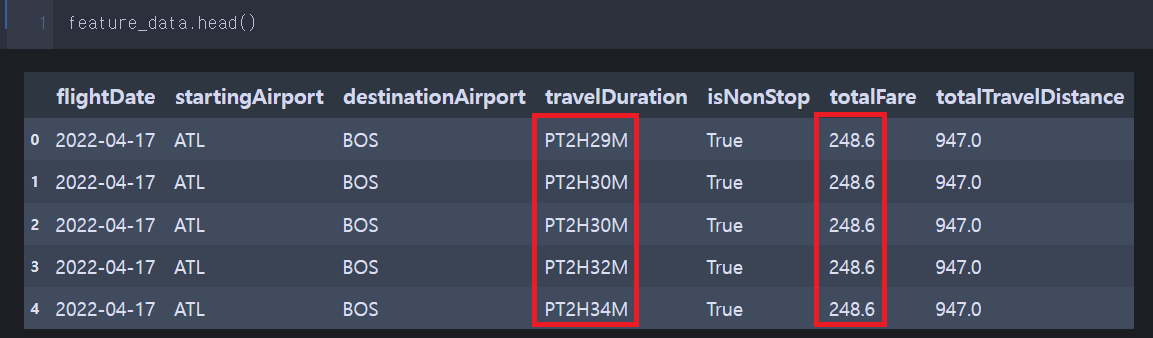

### 참고 3. 중복 제거 후

In [4]:
data.head()

,flightDate,startingAirport,destinationAirport,travelDuration,isNonStop,totalFare,totalTravelDistance
0,2022-04-17,ATL,BOS,PT2H29M,True,248.60,947.0
1,2022-04-17,ATL,BOS,PT4H12M,False,251.10,956.0
2,2022-04-17,ATL,BOS,PT4H46M,False,252.60,947.0
3,2022-04-17,ATL,BOS,PT5H45M,False,252.60,1462.0
4,2022-04-17,ATL,BOS,PT5H39M,False,290.58,NaN
